In [1]:
# imports
import numpy as np
from pylab import *
from preprocessing import get_preprocessed_data, get_test_data
from features import find_peaks
import audioFeatureExtraction

In [2]:
x_dataA, y_labelA, framerate_A = get_preprocessed_data('A', N=2, factor=5)

x_dataB, y_labelB, framerate_B = get_preprocessed_data('B', N=2, factor=1)

In [3]:
print(len(x_dataA[0]))
print(len(x_dataB[0]))

14272
4011


In [4]:
# testing
x_testdataA = get_test_data('A')
x_testdataA = np.array([x[:len(x_dataA[0])] for x in x_testdataA])

In [5]:
# get peaks for A
dataA_peaks = find_peaks(x_dataA, 'A')
testdataA_peaks = find_peaks(x_testdataA, 'A')

In [6]:
def get_S1S2_bounds(data, peaks, set_name):
    #finding difference between all peaks in every file
    all_diffs = []
    for k in range(len(peaks)):
        diff = np.diff(peaks[k])
        all_diffs.append(diff)
    
    #finding max difference or diastole period
    # and then labelling the first peak as s2 and second peak as s1
    max_index = []
    s1s2_peaks = []
    for k in range(len(all_diffs)):
        if any(all_diffs[k]):
            max_index.append(np.argmax(all_diffs[k]))
            s2 = peaks[k][max_index[k]]
            s1 = peaks[k][max_index[k]+1]
            s1s2_peaks.append([s1, s2])
        else:
            max_index.append(-1)
            s1s2_peaks.append([-1,-1])
    s1s2_peaks = np.array(s1s2_peaks)
    
    #defining s1 and s2 boundaries
    s1_bounds = []
    s2_bounds = []
    if set_name == 'A':
        upper_s1 = 200
        lower_s1 = 80
        upper_s2 = 600
        lower_s2 = 70
    else:
        upper_s1 = 200 # change for set b
        lower_s1 = 80 # change for set b 
        upper_s2 = 600 # change for set b 
        lower_s2 = 70 # change for set b
        
    for k in range(len(s1s2_peaks)):
        if s1s2_peaks[k][0] == -1:
            s1_bounds.append([-1,-1])
            s2_bounds.append([-1,-1])
        else:
            s1_lower = s1s2_peaks[k][0]-lower_s1
            s1_upper = s1s2_peaks[k][0]+upper_s1
            s2_lower = s1s2_peaks[k][1]-lower_s2
            s2_upper = s1s2_peaks[k][1]+upper_s2
            if s1_lower < 0:
                s1_lower = 0
            if s2_lower < 0:
                s2_lower = 0
            if s1_upper >= len(data[0]):
                s1_upper = len(data[0]) - 1
            if s2_upper >= len(data[0]):
                s2_upper = len(data[0]) - 1
            s1_bounds.append([s1_lower, s1_upper])
            s2_bounds.append([s2_lower, s2_upper])
        
    return np.array(s1_bounds), np.array(s2_bounds)

In [7]:
#function for plotting class specific points of a feature
def featurePlot(feat, set_name):
    if set_name.upper() == 'A':
        print("Red=artifacts, blue=extrahls, purple=murmur, cyan=normal")
        for i in range(len(feat)):
            if y_labelA[i] == 'artifact':
                scatter(i,feat[i], c='r')
            elif y_labelA[i] == 'extrahls':
                scatter(i,feat[i], c='b')
            elif y_labelA[i] == 'murmur':
                scatter(i,feat[i], c='m')
            elif y_labelA[i] == 'normal':
                scatter(i,feat[i], c='c')
        show()
    else: 
        print("blue=extrastole, purple=murmur, cyan=normal")
        for i in range(len(feat)):
            if y_labelB[i] == 'extrastole':
                scatter(i,feat[i], c='b')
            elif y_labelB[i] == 'murmur':
                scatter(i,feat[i], c='m')
            elif y_labelB[i] == 'normal':
                scatter(i,feat[i], c='c')
        show()
    return

#std deviation of specific interval where
#lower is the left most bound of the interval, upper is right most bound
def stdInterval(lower,low_index,upper,up_index, data):
    std = []
    for k in range(len(data)):
        if lower[k][0] == -1:
            std.append(0)
        else:
            dev = np.std(data[k][lower[k][low_index]:upper[k][up_index]])
            if np.isnan(dev):
                std.append(0)
            else:  
                std.append(dev)
    return np.array(std)

Red=artifacts, blue=extrahls, purple=murmur, cyan=normal


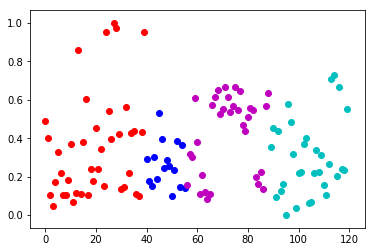

Red=artifacts, blue=extrahls, purple=murmur, cyan=normal


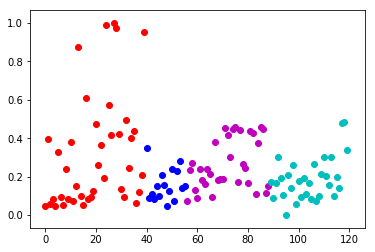

In [8]:
s1_boundsA, s2_boundsA = get_S1S2_bounds(x_dataA, dataA_peaks, 'A')
s1_boundstA, s2_boundstA = get_S1S2_bounds(x_testdataA, testdataA_peaks, 'A')

# Standard deviation of S1
stdS1_A = stdInterval(s1_boundsA,0,s1_boundsA,1, x_dataA)
stdS1_A = stdS1_A/max(stdS1_A)
featurePlot(stdS1_A, 'A')
stdS1_testA = stdInterval(s1_boundstA,0,s1_boundstA,1, x_testdataA)
stdS1_testA = stdS1_testA/max(stdS1_testA)

# Standard deviation of S2
stdS2_A = stdInterval(s2_boundsA,0,s2_boundsA,1, x_dataA)
stdS2_A = stdS2_A/max(stdS2_A)
featurePlot(stdS2_A, 'A')
stdS2_testA = stdInterval(s2_boundstA,0,s2_boundstA,1, x_testdataA)
stdS2_testA = stdS2_testA/max(stdS2_testA)

In [9]:
def freqInterval(data,lower,l_index,upper,u_index):
    freq = []
    for i in range(len(data)):
        if lower[i][0] == -1:
            freq.append(0)
        else:
            temp = data[i][lower[i][l_index]:upper[i][u_index]]
            temp = np.fft.fft(temp)
            temp = np.abs(temp)/max(np.abs(temp))
            #freq.append(temp[:int(len(temp)/2)])
            freq.append(temp)
    return np.array(freq)

Red=artifacts, blue=extrahls, purple=murmur, cyan=normal


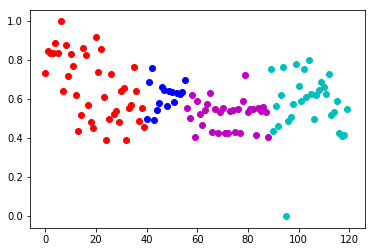

Red=artifacts, blue=extrahls, purple=murmur, cyan=normal


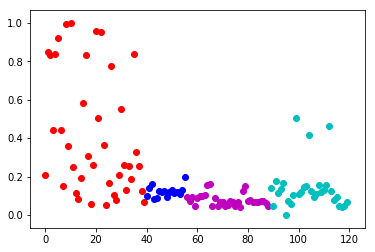

Red=artifacts, blue=extrahls, purple=murmur, cyan=normal


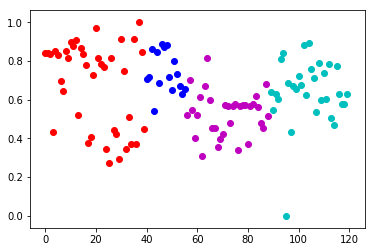

Red=artifacts, blue=extrahls, purple=murmur, cyan=normal


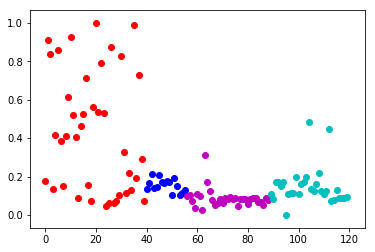

In [10]:
# mean and standard deviation of S1 and S2 frequencies 
freqS1_A = freqInterval(x_dataA, s1_boundsA,0,s1_boundsA,1)
stdS1_freqA = np.array([np.std(f) for f in freqS1_A])
stdS1_freqA = stdS1_freqA/max(stdS1_freqA)
meanS1_freqA = np.array([np.average(f) for f in freqS1_A])
meanS1_freqA = meanS1_freqA/max(meanS1_freqA)
featurePlot(stdS1_freqA, 'A')
featurePlot(meanS1_freqA, 'A')

freqS2_A = freqInterval(x_dataA, s2_boundsA,0,s2_boundsA,1)
stdS2_freqA = np.array([np.std(f) for f in freqS2_A])
stdS2_freqA = stdS2_freqA/max(stdS2_freqA)
meanS2_freqA = np.array([np.average(f) for f in freqS2_A])
meanS2_freqA = meanS2_freqA/max(meanS2_freqA)
featurePlot(stdS2_freqA, 'A')
featurePlot(meanS2_freqA, 'A')

In [ ]:
n = 2
figure()
title(y_labelA[n])
plot(x_dataA[n],'b')
scatter(dataA_peaks[n],x_dataA[n][dataA_peaks[n]],c='r')
show()

In [ ]:
# get peaks for B
dataB_peaks = find_peaks(x_dataB, 'B')

'''n = 140
figure()
title(y_labelB[n])
plot(x_dataB[n],'b')
scatter(dataB_peaks[n],x_dataB[n][dataB_peaks[n]],c='r')
show()'''

In [ ]:
n = 30
figure()
title(y_labelB[n])
plot(x_dataB[n],'b')
scatter(dataB_peaks[n],x_dataB[n][dataB_peaks[n]],c='r')
show()

Red=artifacts, blue=extrahls, purple=murmur, cyan=normal


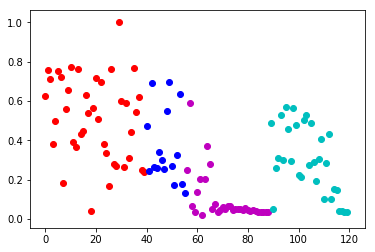

blue=extrastole, purple=murmur, cyan=normal


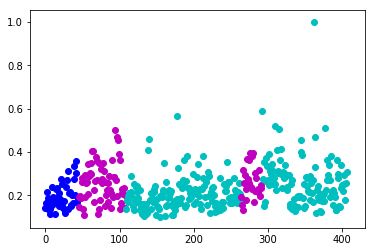

In [11]:
# zero crossing rate of frame 
zero_crossingsA = np.array([audioFeatureExtraction.stZCR(x) for x in x_dataA])
zero_crossingsA = zero_crossingsA/max(zero_crossingsA)
zero_crossingsB = np.array([audioFeatureExtraction.stZCR(x) for x in x_dataB])
zero_crossingsB = zero_crossingsB/max(zero_crossingsB)
zc_testA = np.array([audioFeatureExtraction.stZCR(x) for x in x_testdataA])
zc_testA = zc_testA/max(zc_testA)
#figure()
#scatter(range(0,len(x_dataA)),zero_crossingsA)
#show()
#figure()
#scatter(range(0,len(x_dataB)),zero_crossingsB)
#show()
featurePlot(zero_crossingsA, 'A')
featurePlot(zero_crossingsB, 'B')

Red=artifacts, blue=extrahls, purple=murmur, cyan=normal


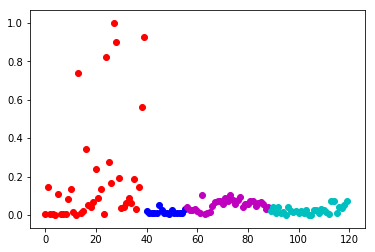

blue=extrastole, purple=murmur, cyan=normal


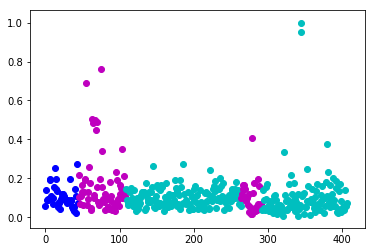

In [12]:
# signal energy of frame
energyA = np.array([audioFeatureExtraction.stEnergy(x) for x in x_dataA])
energyA = energyA/max(energyA)
energyB = np.array([audioFeatureExtraction.stEnergy(x) for x in x_dataB])
energyB = energyB/max(energyB)
ener_testA = np.array([audioFeatureExtraction.stEnergy(x) for x in x_testdataA])
ener_testA = ener_testA/max(ener_testA)
#figure()
#scatter(range(0,len(x_dataA)),energyA)
#show()
#figure()
#scatter(range(0,len(x_dataB)),energyB)
#show()
featurePlot(energyA, 'A')
featurePlot(energyB, 'B')

Red=artifacts, blue=extrahls, purple=murmur, cyan=normal


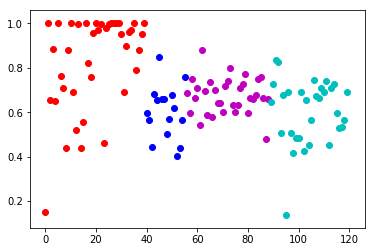

blue=extrastole, purple=murmur, cyan=normal


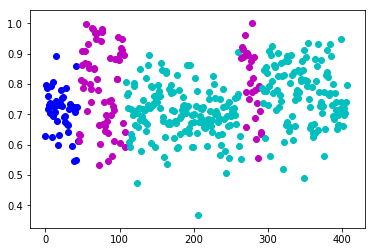

In [13]:
# entropy of energy
entropyA = np.array([audioFeatureExtraction.stEnergyEntropy(x, numOfShortBlocks=50) for x in x_dataA])
entropyA = entropyA/max(entropyA)
entropyB = np.array([audioFeatureExtraction.stEnergyEntropy(x, numOfShortBlocks=50) for x in x_dataB])
entropyB = entropyB/max(entropyB)
entr_testA = np.array([audioFeatureExtraction.stEnergyEntropy(x, numOfShortBlocks=50) for x in x_testdataA])
entr_testA = entr_testA/max(entr_testA)
#figure()
#scatter(range(0,len(x_dataA)),entropyA)
#show()
#figure()
#scatter(range(0,len(x_dataB)),entropyB)
#show()
featurePlot(entropyA, 'A')
featurePlot(entropyB, 'B')

14272


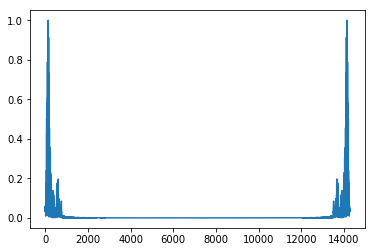

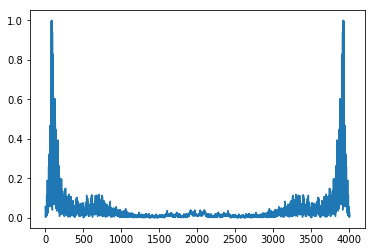

In [14]:
# frequency domain
X_dataA = np.array([np.fft.fft(x) for x in x_dataA])
X_dataA = np.array([np.abs(X)/max(np.abs(X)) for X in X_dataA])
print(len(X_dataA[0]))
figure()
plot(X_dataA[70])
show()

X_testdataA = np.array([np.fft.fft(x) for x in x_testdataA])
X_testdataA = np.array([X[:len(X_dataA[0])] for X in X_testdataA])
X_testdataA = np.array([np.abs(X)/max(np.abs(X)) for X in X_testdataA])
X_testdataA = np.array([X[:len(X)-1] if len(X)%2 == 1 else X for X in X_testdataA])
#Xn_dataA = np.array([nfft(x,2) for x in x_dataA])
#Xn_dataA = np.array([np.abs(X)/max(np.abs(X)) for X in Xn_dataA])
#figure()
#plot(Xn_dataA[70])
#show()

X_dataB = np.array([np.fft.fft(x) for x in x_dataB])
X_dataB = np.array([np.abs(X)/max(np.abs(X)) for X in X_dataB])
figure()
plot(X_dataB[300])
show()

Red=artifacts, blue=extrahls, purple=murmur, cyan=normal


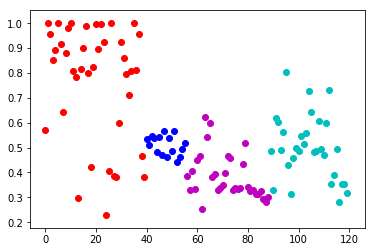

blue=extrastole, purple=murmur, cyan=normal


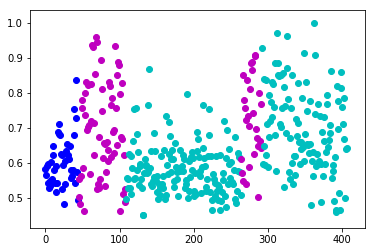

In [15]:
# spectral entropy
entropy_freqA = np.array([audioFeatureExtraction.stSpectralEntropy(X, numOfShortBlocks=150) for X in X_dataA])
entropy_freqA = entropy_freqA/max(entropy_freqA)
entropy_freqB = np.array([audioFeatureExtraction.stSpectralEntropy(X, numOfShortBlocks=50) for X in X_dataB])
entropy_freqB = entropy_freqB/max(entropy_freqB)
entr_freqtestA = np.array([audioFeatureExtraction.stSpectralEntropy(X, numOfShortBlocks=150) for X in X_testdataA])
entr_freqtestA = entr_freqtestA/max(entr_freqtestA)
#figure()
#scatter(range(0,len(X_dataA)),entropy_freqA)
#show()
#figure()
#scatter(range(0,len(X_dataB)),entropy_freqB)
#show()
featurePlot(entropy_freqA, 'A')
featurePlot(entropy_freqB, 'B')

14272
Red=artifacts, blue=extrahls, purple=murmur, cyan=normal


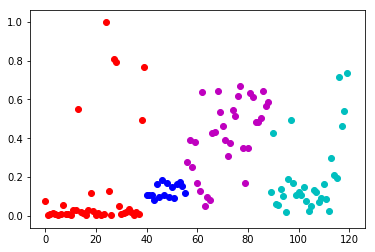

blue=extrastole, purple=murmur, cyan=normal


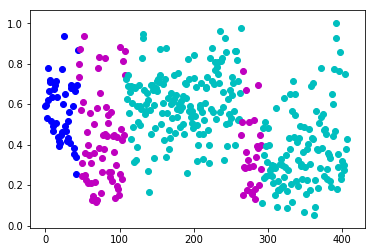

In [16]:
# spectral flux
fluxA = np.array([np.abs(audioFeatureExtraction.stSpectralFlux(X[:int(len(X)/2)], X[int(len(X)/2):])) for X in X_dataA])
fluxA = fluxA/max(fluxA)
fluxB = np.array([np.abs(audioFeatureExtraction.stSpectralFlux(X[:int(len(X)/2)], X[int(len(X)/2)+1:])) for X in X_dataB])
fluxB = fluxB/max(fluxB)
print(len(X_testdataA[0]))
flux_testA = np.array([np.abs(audioFeatureExtraction.stSpectralFlux(X[:int(len(X)/2)], X[int(len(X)/2):])) for X in X_testdataA])
flux_testA = flux_testA/max(flux_testA)
#figure()
#scatter(range(0,len(X_dataA)),fluxA)
#show()
#figure()
#scatter(range(0,len(X_dataB)),fluxB)
#show()
featurePlot(fluxA, 'A')
featurePlot(fluxB, 'B')

Red=artifacts, blue=extrahls, purple=murmur, cyan=normal


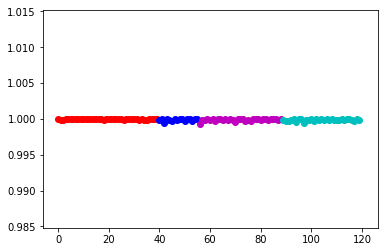

Red=artifacts, blue=extrahls, purple=murmur, cyan=normal


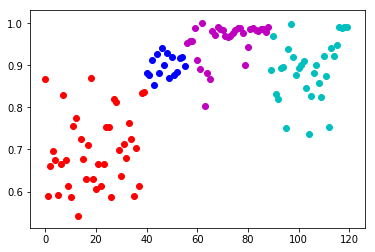

blue=extrastole, purple=murmur, cyan=normal


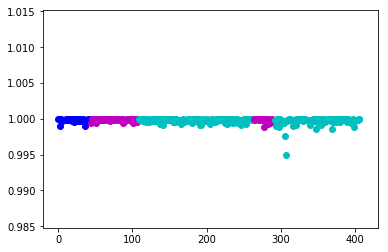

blue=extrastole, purple=murmur, cyan=normal


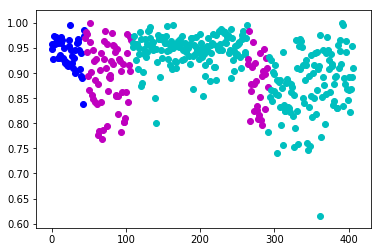

In [17]:
# spectral centroid of frame (given abs(FFT))
FsA = int(framerate_A[0]/20) # framerate is the same for all of set A
FsB = int(framerate_B[0]/10) # framerate is the same for all of set B

centroidA = np.array([audioFeatureExtraction.stSpectralCentroidAndSpread(np.abs(X),FsA) for X in X_dataA])
centroidA[:,0] = centroidA[:,0]/max(centroidA[:,0])
centroidA[:,1] = centroidA[:,1]/max(centroidA[:,1])
centroidB = np.array([audioFeatureExtraction.stSpectralCentroidAndSpread(np.abs(X),FsB) for X in X_dataB])
centroidB[:,0] = centroidB[:,0]/max(centroidB[:,0])
centroidB[:,1] = centroidB[:,1]/max(centroidB[:,1])
cent_testA = np.array([audioFeatureExtraction.stSpectralCentroidAndSpread(np.abs(X),FsA) for X in X_testdataA])
cent_testA[:,0] = cent_testA[:,0]/max(cent_testA[:,0])
cent_testA[:,1] = cent_testA[:,1]/max(cent_testA[:,1])
#figure()
#scatter(range(0,len(X_dataA)),centroidA[:,0]) #centroid of A
#show()
#figure()
#scatter(range(0,len(X_dataA)),centroidA[:,1]) #spread of A
#show()
#figure()
#scatter(range(0,len(X_dataB)),centroidB[:,0]) #centroid of B
#show()
#figure()
#scatter(range(0,len(X_dataB)),centroidB[:,1]) #spread of B
#show()
featurePlot(centroidA[:,0], 'A')
featurePlot(centroidA[:,1], 'A')
featurePlot(centroidB[:,0], 'B')
featurePlot(centroidB[:,1], 'B')

Red=artifacts, blue=extrahls, purple=murmur, cyan=normal


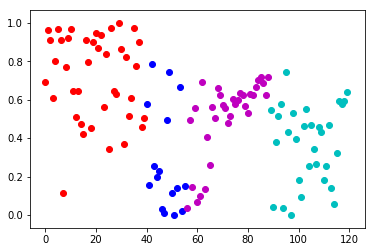

Red=artifacts, blue=extrahls, purple=murmur, cyan=normal


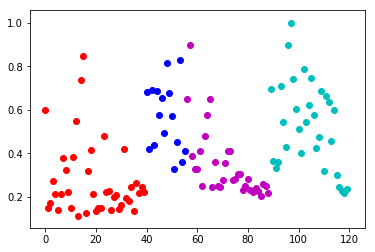

blue=extrastole, purple=murmur, cyan=normal


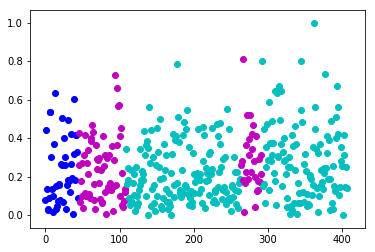

blue=extrastole, purple=murmur, cyan=normal


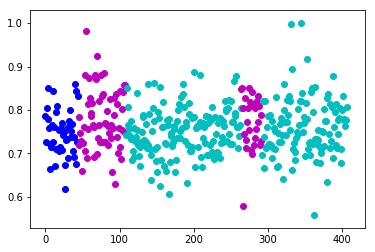

In [19]:
FsA = int(framerate_A[0]/10) # framerate is the same for all of set A
FsB = int(framerate_B[0]/4) # framerate is the same for all of set B

from python_speech_features import mfcc

mfccA = np.array([mfcc(np.abs(x),samplerate=FsA, numcep=3,winlen=0.025) for x in x_dataA])
mfccA_feat = np.array([[np.average(m[:,0]), np.std(m[:,0]), np.average(m[:,1]), np.std(m[:,1]), np.average(m[:,2]), np.std(m[:,2])] for m in mfccA])
for i in range(len(mfccA_feat[0])):
    mfccA_feat[:,i] = np.abs(mfccA_feat[:,i])/max(np.abs(mfccA_feat[:,i]))

mfccB = np.array([mfcc(np.abs(x),samplerate=FsB, numcep=5,winlen=0.01, winstep=0.01) for x in x_dataB])
mfccB_feat = np.array([[np.average(m[:,0]), np.std(m[:,0]), np.average(m[:,1]), np.std(m[:,1]), np.average(m[:,2]), np.std(m[:,2])] for m in mfccB])
for i in range(len(mfccB_feat[0])):
    mfccB_feat[:,i] = np.abs(mfccB_feat[:,i])/max(np.abs(mfccB_feat[:,i]))

mfcc_testA = np.array([mfcc(np.abs(x),samplerate=FsA, numcep=3,winlen=0.025) for x in x_testdataA])
mfcctestA_feat = np.array([[np.average(m[:,0]), np.std(m[:,0]), np.average(m[:,1]), np.std(m[:,1]), np.average(m[:,2]), np.std(m[:,2])] for m in mfcc_testA])
for i in range(len(mfccA_feat[0])):
    mfccA_feat[:,i] = np.abs(mfccA_feat[:,i])/max(np.abs(mfccA_feat[:,i]))

#figure()
#plot(mfccA_feat)
#show()
#figure()
#plot(mfccB_feat)
#show()
featurePlot(mfccA_feat[:,2],'A')
featurePlot(mfccA_feat[:,3],'A')
featurePlot(mfccB_feat[:,2],'B')
featurePlot(mfccB_feat[:,3],'B')

In [20]:
# features to use
# zero_crossings, energy, entropy, entropy frequency, flux, spread, mfcc #fluxA, flux_testA, fluxB
x_utrainA = np.column_stack((zero_crossingsA, energyA, entropyA, entropy_freqA, fluxA, centroidA[:,1], mfccA_feat, stdS1_A, stdS2_A, stdS1_freqA, meanS1_freqA, stdS2_freqA, meanS2_freqA))
x_utestA = np.column_stack((zc_testA, ener_testA, entr_testA, entr_freqtestA, flux_testA, cent_testA[:,1],mfcctestA_feat, stdS1_testA, stdS2_testA))

x_utrainB = np.column_stack((zero_crossingsB, energyB, entropyB, entropy_freqB, fluxB, centroidB[:,1],mfccB_feat))
print(x_utrainA.shape)
print(x_utrainB.shape)
print(x_utestA.shape)

(120, 18)
(407, 12)
(52, 14)


In [21]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
y_utrainA = le.fit_transform(y_labelA) # 0 - artifact, 1 - extrahls, 2 - murmur, 3 - normal
print(le.classes_)
y_utrainB = le.fit_transform(y_labelB)
print(le.classes_)
print(y_utrainA.shape)
print(y_utrainB.shape)

['artifact' 'extrahls' 'murmur' 'normal']
['extrastole' 'murmur' 'normal']
(120,)
(407,)


In [22]:
from sklearn.utils import shuffle

#shuffle data 
x_trainA, y_trainA = shuffle(x_utrainA, y_utrainA, random_state=3) 
x_trainB, y_trainB = shuffle(x_utrainB, y_utrainB, random_state=0) 

In [23]:
from sklearn.model_selection import KFold

# split kfold data
kf = KFold(n_splits=4, shuffle=False, random_state=1)

In [24]:
# priors of each class
numA = {0:0, 1:0, 2:0, 3:0}
numB = {0:0, 1:0, 2:0}
for y in y_trainA:
    numA[y] += 1

for y in y_trainB:
    numB[y] += 1
    
priorsA = [0,0,0,0]
priorsB = [0,0,0]

for i in range(4):
    priorsA[i] = numA[i]/len(x_trainA)
for i in range(3):
    priorsB[i] = numB[i]/len(x_trainB)
print(priorsA)
print(priorsB)

[0.3333333333333333, 0.13333333333333333, 0.275, 0.25833333333333336]
[0.11056511056511056, 0.22604422604422605, 0.6633906633906634]


In [25]:
from sklearn.naive_bayes import GaussianNB

resultsA_gnb = []
gnbA = [] # the models are saved here 
i = 0
precisionsA = {0: [], 1:[], 2:[], 3:[]}

for train_index, test_index in kf.split(x_trainA):
    TP_A = {0:0, 1:0, 2:0, 3:0}
    FP_A = {0:0, 1:0, 2:0, 3:0}
    gnbA.append(GaussianNB(priorsA))
    resultsA_gnb.append(gnbA[i].fit(x_trainA[train_index], y_trainA[train_index]).score(x_trainA[test_index],y_trainA[test_index]))
    preds = gnbA[i].predict(x_trainA[test_index])
    actual = y_trainA[test_index]
    print('Predic ',i, ': ', preds)
    print('Actual ',i, ': ', actual)
    for p in range(len(preds)):
        if preds[p] == actual[p]:
            TP_A[preds[p]] += 1
        else:
            FP_A[preds[p]] += 1
    print(TP_A)
    print(FP_A)
    for n in range(4):
        if TP_A[n] == 0 and FP_A[n] == 0 :
            precisionsA[n].append(0)
        else:
            precisionsA[n].append(float(TP_A[n]/(TP_A[n]+FP_A[n])))
    i += 1
resultsA_gnb = np.array(resultsA_gnb)
print('Precisions: ', precisionsA)
print('Average Precisions: ', np.average(precisionsA[0]), np.average(precisionsA[1]), np.average(precisionsA[2]), np.average(precisionsA[3]))
print('Accuracy of splits: ', resultsA_gnb)
print('Average results: ', np.average(resultsA_gnb))

Predic  0 :  [3 0 0 1 1 0 2 0 3 0 2 1 1 2 1 0 3 3 3 0 3 3 1 2 2 2 0 2 1 0]
Actual  0 :  [3 3 0 3 3 0 2 0 3 0 3 1 3 2 1 0 2 3 1 0 0 3 1 3 2 2 0 2 3 0]
{0: 8, 1: 3, 2: 5, 3: 4}
{0: 1, 1: 4, 2: 2, 3: 3}
Predic  1 :  [0 2 0 1 2 2 2 1 3 3 2 2 1 1 0 2 0 3 2 0 1 1 2 0 1 0 0 0 0 2]
Actual  1 :  [0 2 0 3 2 2 2 1 3 3 2 2 3 2 0 2 0 0 2 0 3 1 2 0 2 0 0 0 0 2]
{0: 10, 1: 2, 2: 10, 3: 2}
{0: 0, 1: 5, 2: 0, 3: 1}
Predic  2 :  [1 1 1 2 3 2 1 2 1 2 2 3 2 1 2 1 0 1 1 3 0 1 2 0 3 3 2 2 0 2]
Actual  2 :  [3 1 1 2 3 2 1 2 3 3 2 3 0 2 3 1 0 3 1 3 0 1 2 0 1 0 2 3 0 2]
{0: 4, 1: 6, 2: 7, 3: 3}
{0: 0, 1: 4, 2: 4, 3: 2}
Predic  3 :  [1 0 1 3 0 2 0 2 2 0 0 0 1 1 0 3 0 2 0 1 1 2 0 0 3 2 2 0 0 1]
Actual  3 :  [1 0 2 2 0 2 0 3 2 0 0 0 3 1 0 3 0 3 0 1 3 2 0 0 0 2 2 0 0 3]
{0: 13, 1: 3, 2: 5, 3: 1}
{0: 0, 1: 4, 2: 2, 3: 2}
Precisions:  {0: [0.8888888888888888, 1.0, 1.0, 1.0], 1: [0.42857142857142855, 0.2857142857142857, 0.6, 0.42857142857142855], 2: [0.7142857142857143, 1.0, 0.6363636363636364, 0.7142857142857143], 3

In [26]:
from sklearn.naive_bayes import GaussianNB

resultsB_gnb = []
gnbB = [] # the models are saved here 
i = 0
precisionsB = {0: [], 1:[], 2:[]}

for train_index, test_index in kf.split(x_trainB):
    TP_B = {0:0, 1:0, 2:0, 3:0}
    FP_B = {0:0, 1:0, 2:0, 3:0}
    gnbB.append(GaussianNB(priorsB))
    resultsB_gnb.append(gnbB[i].fit(x_trainB[train_index], y_trainB[train_index]).score(x_trainB[test_index],y_trainB[test_index]))
    preds = gnbB[i].predict(x_trainB[test_index])
    actual = y_trainB[test_index]
    print('Predic ',i, ': ', preds)
    print('Actual ',i, ': ', actual)
    for p in range(len(preds)):
        if preds[p] == actual[p]:
            TP_B[preds[p]] += 1
        else:
            FP_B[preds[p]] += 1
    print(TP_B)
    print(FP_B)
    for n in range(3):
        if TP_B[n] == 0 and FP_B[n] == 0 :
            precisionsB[n].append(0)
        else:
            precisionsB[n].append(float(TP_B[n]/(TP_B[n]+FP_B[n])))
    i += 1
resultsB_gnb = np.array(resultsB_gnb)
print('Precisions: ', precisionsB)
print('Average Precisions: ', np.average(precisionsB[0]), np.average(precisionsB[1]), np.average(precisionsB[2]))
print('Accuracy of splits: ', resultsB_gnb)
print('Average results: ', np.average(resultsB_gnb))

Predic  0 :  [0 2 2 0 0 2 2 0 2 1 1 2 0 0 0 2 1 0 1 1 1 2 1 2 1 2 2 0 2 2 0 0 0 0 0 1 1
 0 0 1 0 2 1 0 2 2 2 1 1 1 2 2 1 0 1 1 2 2 1 2 0 0 0 2 2 0 2 0 0 0 2 0 1 0
 2 0 1 0 2 2 0 2 2 1 1 1 1 0 0 2 0 2 1 0 2 2 0 0 1 0 2 0]
Actual  0 :  [2 2 1 2 2 2 2 2 2 1 2 2 2 2 0 2 1 2 2 1 2 2 2 2 2 2 2 2 0 2 2 2 2 1 0 1 2
 2 2 1 2 2 2 2 0 0 2 2 1 1 2 2 2 2 2 1 2 2 2 1 0 0 1 1 2 0 2 2 2 2 0 2 2 2
 0 0 1 0 2 0 2 2 2 2 1 1 1 2 2 2 1 2 2 2 2 2 2 2 1 0 2 2]
{0: 8, 1: 13, 2: 27, 3: 0}
{0: 31, 1: 14, 2: 9, 3: 0}
Predic  1 :  [2 2 1 0 1 1 1 2 0 0 2 0 0 2 0 0 1 2 1 2 2 0 0 0 1 2 2 2 0 0 0 0 0 2 2 2 2
 1 2 1 0 1 1 0 0 2 1 0 0 2 2 2 2 0 0 2 2 2 0 2 2 2 0 2 1 2 0 2 1 2 1 2 0 0
 2 1 2 2 0 0 0 1 0 0 2 0 0 2 2 2 2 1 1 0 1 2 0 0 0 2 0 1]
Actual  1 :  [1 2 1 2 1 2 1 2 2 1 2 1 1 2 2 2 1 2 1 2 0 2 2 2 1 2 2 1 2 2 2 2 2 1 2 2 1
 2 2 2 0 2 2 0 2 2 1 2 2 2 2 2 2 2 2 2 2 1 2 2 2 1 2 0 2 2 0 2 1 1 1 2 2 2
 2 2 2 2 1 2 1 2 2 2 1 2 2 2 2 0 2 2 1 1 2 2 0 0 2 2 2 2]
{0: 5, 1: 10, 2: 31, 3: 0}
{0: 34, 1: 11, 2: 11, 3: 0}
Predic 

In [27]:
from sklearn.ensemble import AdaBoostClassifier

resultsA_adaNB = []
adaNBA = []
i = 0
precisionsA = {0: [], 1:[], 2:[], 3:[]}
for train_index, test_index in kf.split(x_trainA):
    TP_A = {0:0, 1:0, 2:0, 3:0}
    FP_A = {0:0, 1:0, 2:0, 3:0}
    gnb = GaussianNB(priorsA)
    adaNBA.append(AdaBoostClassifier(base_estimator=gnb, learning_rate=0.001, n_estimators=100))
    resultsA_adaNB.append(adaNBA[i].fit(x_trainA[train_index], y_trainA[train_index]).score(x_trainA[test_index],y_trainA[test_index]))
    preds = adaNBA[i].predict(x_trainA[test_index])
    actual = y_trainA[test_index]
    print('Predic ',i, ': ', preds)
    print('Actual ',i, ': ', actual)
    for p in range(len(preds)):
        if preds[p] == actual[p]:
            TP_A[preds[p]] += 1
        else:
            FP_A[preds[p]] += 1
    print(TP_A)
    print(FP_A)
    for n in range(4):
        if TP_A[n] == 0 and FP_A[n] == 0 :
            precisionsA[n].append(0)
        else:
            precisionsA[n].append(float(TP_A[n]/(TP_A[n]+FP_A[n])))
    i += 1
resultsA_adaNB = np.array(resultsA_adaNB)
print('Precisions: ', precisionsA)
print('Average Precisions: ', np.average(precisionsA[0]), np.average(precisionsA[1]), np.average(precisionsA[2]), np.average(precisionsA[3]))
print('Accuracy of splits: ', resultsA_adaNB)
print('Average results: ', np.average(resultsA_adaNB))

Predic  0 :  [3 0 0 1 1 0 2 0 0 0 2 1 1 2 1 0 2 3 3 0 0 3 1 2 2 2 0 2 1 0]
Actual  0 :  [3 3 0 3 3 0 2 0 3 0 3 1 3 2 1 0 2 3 1 0 0 3 1 3 2 2 0 2 3 0]
{0: 9, 1: 3, 2: 6, 3: 3}
{0: 2, 1: 4, 2: 2, 3: 1}
Predic  1 :  [0 2 0 1 2 2 2 1 3 3 2 2 1 1 0 2 0 0 2 0 1 1 2 0 1 0 0 0 0 2]
Actual  1 :  [0 2 0 3 2 2 2 1 3 3 2 2 3 2 0 2 0 0 2 0 3 1 2 0 2 0 0 0 0 2]
{0: 11, 1: 2, 2: 10, 3: 2}
{0: 0, 1: 5, 2: 0, 3: 0}
Predic  2 :  [3 3 1 2 3 2 1 2 1 2 2 3 2 1 2 1 0 1 1 0 0 1 2 0 3 3 2 2 0 2]
Actual  2 :  [3 1 1 2 3 2 1 2 3 3 2 3 0 2 3 1 0 3 1 3 0 1 2 0 1 0 2 3 0 2]
{0: 4, 1: 5, 2: 7, 3: 3}
{0: 1, 1: 3, 2: 4, 3: 3}
Predic  3 :  [1 0 1 3 0 2 0 2 2 0 0 0 1 1 0 2 0 2 0 1 1 2 0 0 3 2 2 0 0 1]
Actual  3 :  [1 0 2 2 0 2 0 3 2 0 0 0 3 1 0 3 0 3 0 1 3 2 0 0 0 2 2 0 0 3]
{0: 13, 1: 3, 2: 5, 3: 0}
{0: 0, 1: 4, 2: 3, 3: 2}
Precisions:  {0: [0.8181818181818182, 1.0, 0.8, 1.0], 1: [0.42857142857142855, 0.2857142857142857, 0.625, 0.42857142857142855], 2: [0.75, 1.0, 0.6363636363636364, 0.625], 3: [0.75, 1.0, 0.5, 0.0]}


In [28]:
resultsB_adaNB = []
adaNBB = []
i = 0
precisionsB = {0: [], 1:[], 2:[]}
for train_index, test_index in kf.split(x_trainB):
    TP_B = {0:0, 1:0, 2:0}
    FP_B = {0:0, 1:0, 2:0}
    gnb = GaussianNB()
    adaNBB.append(AdaBoostClassifier(base_estimator=gnb, learning_rate=0.001, n_estimators=100))
    resultsB_adaNB.append(adaNBB[i].fit(x_trainB[train_index], y_trainB[train_index]).score(x_trainB[test_index],y_trainB[test_index]))
    preds = adaNBB[i].predict(x_trainB[test_index])
    actual = y_trainB[test_index]
    print('Predic ',i, ': ', preds)
    print('Actual ',i, ': ', actual)
    for p in range(len(preds)):
        if preds[p] == actual[p]:
            TP_B[preds[p]] += 1
        else:
            FP_B[preds[p]] += 1
    print(TP_B)
    print(FP_B)
    for n in range(3):
        if TP_B[n] == 0 and FP_B[n] == 0 :
            precisionsB[n].append(0)
        else:
            precisionsB[n].append(float(TP_B[n]/(TP_B[n]+FP_B[n])))
    i += 1
resultsB_adaNB = np.array(resultsB_adaNB)
print('Precisions: ', precisionsB)
print('Average Precisions: ', np.average(precisionsB[0]), np.average(precisionsB[1]), np.average(precisionsB[2]))
print('Accuracy of splits: ', resultsB_adaNB)
print('Average results: ', np.average(resultsB_adaNB))

Predic  0 :  [0 2 2 2 0 2 2 2 2 1 1 2 2 0 0 2 1 2 1 1 1 2 1 2 1 2 2 0 2 1 2 2 2 0 2 1 1
 2 0 1 0 2 1 0 2 2 1 1 1 1 2 2 1 0 1 1 2 2 1 2 0 2 0 2 2 0 2 0 2 0 2 0 1 0
 2 2 1 2 2 2 0 1 2 1 1 1 1 0 0 2 0 2 1 2 2 2 2 0 1 2 2 2]
Actual  0 :  [2 2 1 2 2 2 2 2 2 1 2 2 2 2 0 2 1 2 2 1 2 2 2 2 2 2 2 2 0 2 2 2 2 1 0 1 2
 2 2 1 2 2 2 2 0 0 2 2 1 1 2 2 2 2 2 1 2 2 2 1 0 0 1 1 2 0 2 2 2 2 0 2 2 2
 0 0 1 0 2 0 2 2 2 2 1 1 1 2 2 2 1 2 2 2 2 2 2 2 1 0 2 2]
{0: 3, 1: 13, 2: 36}
{0: 19, 1: 17, 2: 14}
Predic  1 :  [2 2 1 0 1 1 1 2 0 2 2 0 0 2 0 0 1 2 1 2 2 0 0 0 1 2 2 2 0 0 0 0 0 2 2 2 2
 1 2 1 2 1 1 0 0 2 1 0 0 2 2 2 1 2 0 1 2 2 0 2 2 2 0 2 1 2 0 2 1 2 1 2 0 0
 2 1 2 2 0 0 2 1 0 0 2 0 0 2 2 1 2 1 1 2 1 2 2 2 0 2 0 1]
Actual  1 :  [1 2 1 2 1 2 1 2 2 1 2 1 1 2 2 2 1 2 1 2 0 2 2 2 1 2 2 1 2 2 2 2 2 1 2 2 1
 2 2 2 0 2 2 0 2 2 1 2 2 2 2 2 2 2 2 2 2 1 2 2 2 1 2 0 2 2 0 2 1 1 1 2 2 2
 2 2 2 2 1 2 1 2 2 2 1 2 2 2 2 0 2 2 1 1 2 2 0 0 2 2 2 2]
{0: 2, 1: 10, 2: 30}
{0: 30, 1: 14, 2: 16}
Predic  2 :  [2 0 2 1 1 2 0 2 

In [29]:
from sklearn.svm import SVC

resultsA_svm = []
svmA = [] # the models are saved here 
i = 0
precisionsA = {0: [], 1:[], 2:[], 3:[]}

for train_index, test_index in kf.split(x_trainA):
    TP_A = {0:0, 1:0, 2:0, 3:0}
    FP_A = {0:0, 1:0, 2:0, 3:0}
    svmA.append(SVC(C=10))
    resultsA_svm.append(svmA[i].fit(x_trainA[train_index], y_trainA[train_index]).score(x_trainA[test_index],y_trainA[test_index]))
    preds = svmA[i].predict(x_trainA[test_index])
    actual = y_trainA[test_index]
    print('Predic ',i, ': ', preds)
    print('Actual ',i, ': ', actual)
    for p in range(len(preds)):
        if preds[p] == actual[p]:
            TP_A[preds[p]] += 1
        else:
            FP_A[preds[p]] += 1
    print(TP_A)
    print(FP_A)
    for n in range(4):
        if TP_A[n] == 0 and FP_A[n] == 0 :
            precisionsA[n].append(0)
        else:
            precisionsA[n].append(float(TP_A[n]/(TP_A[n]+FP_A[n])))
    i += 1
resultsA_svm = np.array(resultsA_svm)
print('Precisions: ', precisionsA)
print('Average Precisions: ', np.average(precisionsA[0]), np.average(precisionsA[1]), np.average(precisionsA[2]), np.average(precisionsA[3]))
print('Accuracy of splits: ', resultsA_svm)
print('Average results: ', np.average(resultsA_svm))

Predic  0 :  [3 0 0 3 3 0 2 0 3 0 2 3 3 2 3 0 3 1 3 0 0 3 3 2 2 2 0 2 3 0]
Actual  0 :  [3 3 0 3 3 0 2 0 3 0 3 1 3 2 1 0 2 3 1 0 0 3 1 3 2 2 0 2 3 0]
{0: 9, 1: 0, 2: 5, 3: 7}
{0: 1, 1: 1, 2: 2, 3: 5}
Predic  1 :  [0 2 0 3 2 2 2 3 3 3 3 2 3 3 0 2 0 0 2 0 3 3 2 0 3 0 0 0 0 2]
Actual  1 :  [0 2 0 3 2 2 2 1 3 3 2 2 3 2 0 2 0 0 2 0 3 1 2 0 2 0 0 0 0 2]
{0: 11, 1: 0, 2: 9, 3: 5}
{0: 0, 1: 0, 2: 0, 3: 5}
Predic  2 :  [3 3 3 2 3 2 3 2 3 2 2 3 2 3 3 3 0 3 3 3 0 3 2 0 3 3 2 2 0 2]
Actual  2 :  [3 1 1 2 3 2 1 2 3 3 2 3 0 2 3 1 0 3 1 3 0 1 2 0 1 0 2 3 0 2]
{0: 4, 1: 0, 2: 7, 3: 7}
{0: 0, 1: 0, 2: 3, 3: 9}
Predic  3 :  [3 0 3 3 0 2 0 3 2 0 0 0 3 3 0 3 0 3 0 3 3 2 0 0 3 2 3 0 0 3]
Actual  3 :  [1 0 2 2 0 2 0 3 2 0 0 0 3 1 0 3 0 3 0 1 3 2 0 0 0 2 2 0 0 3]
{0: 13, 1: 0, 2: 4, 3: 6}
{0: 0, 1: 0, 2: 0, 3: 7}
Precisions:  {0: [0.9, 1.0, 1.0, 1.0], 1: [0.0, 0, 0, 0], 2: [0.7142857142857143, 1.0, 0.7, 1.0], 3: [0.5833333333333334, 0.5, 0.4375, 0.46153846153846156]}
Average Precisions:  0.975 0.0 0.85357142

In [30]:
resultsB_svm = []
svmB = [] # the models are saved here 
i = 0
precisionsB = {0: [], 1:[], 2:[]}

for train_index, test_index in kf.split(x_trainB):
    TP_B = {0:0, 1:0, 2:0, 3:0}
    FP_B = {0:0, 1:0, 2:0, 3:0}
    svmB.append(SVC(C=1000))
    resultsB_svm.append(svmB[i].fit(x_trainB[train_index], y_trainB[train_index]).score(x_trainB[test_index],y_trainB[test_index]))
    preds = svmB[i].predict(x_trainB[test_index])
    actual = y_trainB[test_index]
    print('Predic ',i, ': ', preds)
    print('Actual ',i, ': ', actual)
    for p in range(len(preds)):
        if preds[p] == actual[p]:
            TP_B[preds[p]] += 1
        else:
            FP_B[preds[p]] += 1
    print(TP_B)
    print(FP_B)
    for n in range(3):
        if TP_B[n] == 0 and FP_B[n] == 0 :
            precisionsB[n].append(0)
        else:
            precisionsB[n].append(float(TP_B[n]/(TP_B[n]+FP_B[n])))
    i += 1
resultsB_svm = np.array(resultsB_svm)
print('Precisions: ', precisionsB)
print('Average Precisions: ', np.average(precisionsB[0]), np.average(precisionsB[1]), np.average(precisionsB[2]))
print('Accuracy of splits: ', resultsB_svm)
print('Average results: ', np.average(resultsB_svm))

Predic  0 :  [2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 1 2 2 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2
 2 2 1 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 1 2 2 1 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2
 2 2 1 2 2 2 2 2 2 2 1 1 1 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2]
Actual  0 :  [2 2 1 2 2 2 2 2 2 1 2 2 2 2 0 2 1 2 2 1 2 2 2 2 2 2 2 2 0 2 2 2 2 1 0 1 2
 2 2 1 2 2 2 2 0 0 2 2 1 1 2 2 2 2 2 1 2 2 2 1 0 0 1 1 2 0 2 2 2 2 0 2 2 2
 0 0 1 0 2 0 2 2 2 2 1 1 1 2 2 2 1 2 2 2 2 2 2 2 1 0 2 2]
{0: 0, 1: 13, 2: 67, 3: 0}
{0: 0, 1: 2, 2: 20, 3: 0}
Predic  1 :  [2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 1 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 1 2 1 2 2 2
 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
Actual  1 :  [1 2 1 2 1 2 1 2 2 1 2 1 1 2 2 2 1 2 1 2 0 2 2 2 1 2 2 1 2 2 2 2 2 1 2 2 1
 2 2 2 0 2 2 0 2 2 1 2 2 2 2 2 2 2 2 2 2 1 2 2 2 1 2 0 2 2 0 2 1 1 1 2 2 2
 2 2 2 2 1 2 1 2 2 2 1 2 2 2 2 0 2 2 1 1 2 2 0 0 2 2 2 2]
{0: 0, 1: 6, 2: 68, 3: 0}
{0: 0, 1: 2, 2: 26, 3: 0}
Predic  2 :

In [31]:
from sklearn.tree import DecisionTreeClassifier

resultsA_dt = []
dtA = [] # the models are saved here 
i = 0
precisionsA = {0: [], 1:[], 2:[], 3:[]}

for train_index, test_index in kf.split(x_trainA):
    TP_A = {0:0, 1:0, 2:0, 3:0}
    FP_A = {0:0, 1:0, 2:0, 3:0}
    dtA.append(DecisionTreeClassifier())
    resultsA_dt.append(dtA[i].fit(x_trainA[train_index], y_trainA[train_index]).score(x_trainA[test_index],y_trainA[test_index]))
    preds = dtA[i].predict(x_trainA[test_index])
    actual = y_trainA[test_index]
    print('Predic ',i, ': ', preds)
    print('Actual ',i, ': ', actual)
    for p in range(len(preds)):
        if preds[p] == actual[p]:
            TP_A[preds[p]] += 1
        else:
            FP_A[preds[p]] += 1
    print(TP_A)
    print(FP_A)
    for n in range(4):
        if TP_A[n] == 0 and FP_A[n] == 0 :
            precisionsA[n].append(0)
        else:
            precisionsA[n].append(float(TP_A[n]/(TP_A[n]+FP_A[n])))
    i += 1
resultsA_dt = np.array(resultsA_dt)
print('Precisions: ', precisionsA)
print('Average Precisions: ', np.average(precisionsA[0]), np.average(precisionsA[1]), np.average(precisionsA[2]), np.average(precisionsA[3]))
print('Accuracy of splits: ', resultsA_dt)
print('Average results: ', np.average(resultsA_dt))

Predic  0 :  [3 2 0 2 3 2 2 0 0 0 3 3 3 2 0 0 3 2 1 2 2 3 1 1 2 2 0 3 3 0]
Actual  0 :  [3 3 0 3 3 0 2 0 3 0 3 1 3 2 1 0 2 3 1 0 0 3 1 3 2 2 0 2 3 0]
{0: 6, 1: 2, 2: 4, 3: 6}
{0: 2, 1: 1, 2: 6, 3: 3}
Predic  1 :  [3 2 0 3 2 3 2 3 3 1 2 2 1 3 0 2 0 0 2 0 3 2 3 0 0 0 0 0 0 2]
Actual  1 :  [0 2 0 3 2 2 2 1 3 3 2 2 3 2 0 2 0 0 2 0 3 1 2 0 2 0 0 0 0 2]
{0: 10, 1: 0, 2: 8, 3: 3}
{0: 1, 1: 2, 2: 1, 3: 5}
Predic  2 :  [3 3 2 2 0 3 1 2 3 2 2 1 2 3 2 1 0 1 1 3 0 1 2 0 3 2 2 3 3 2]
Actual  2 :  [3 1 1 2 3 2 1 2 3 3 2 3 0 2 3 1 0 3 1 3 0 1 2 0 1 0 2 3 0 2]
{0: 3, 1: 4, 2: 6, 3: 4}
{0: 1, 1: 2, 2: 5, 3: 5}
Predic  3 :  [0 0 1 0 0 2 0 2 2 0 0 1 1 3 0 1 3 1 0 3 2 2 0 0 1 2 2 0 0 3]
Actual  3 :  [1 0 2 2 0 2 0 3 2 0 0 0 3 1 0 3 0 3 0 1 3 2 0 0 0 2 2 0 0 3]
{0: 11, 1: 0, 2: 5, 3: 1}
{0: 2, 1: 6, 2: 2, 3: 3}
Precisions:  {0: [0.75, 0.9090909090909091, 0.75, 0.8461538461538461], 1: [0.6666666666666666, 0.0, 0.6666666666666666, 0.0], 2: [0.4, 0.8888888888888888, 0.5454545454545454, 0.7142857142857143], 3:

In [ ]:
resultsB_dt = []
dtB = [] # the models are saved here 
i = 0
precisionsB = {0: [], 1:[], 2:[]}

for train_index, test_index in kf.split(x_trainB):
    TP_B = {0:0, 1:0, 2:0, 3:0}
    FP_B = {0:0, 1:0, 2:0, 3:0}
    dtB.append(DecisionTreeClassifier())
    resultsB_dt.append(dtB[i].fit(x_trainB[train_index], y_trainB[train_index]).score(x_trainB[test_index],y_trainB[test_index]))
    preds = dtB[i].predict(x_trainB[test_index])
    actual = y_trainB[test_index]
    print('Predic ',i, ': ', preds)
    print('Actual ',i, ': ', actual)
    for p in range(len(preds)):
        if preds[p] == actual[p]:
            TP_B[preds[p]] += 1
        else:
            FP_B[preds[p]] += 1
    print(TP_B)
    print(FP_B)
    for n in range(3):
        if TP_B[n] == 0 and FP_B[n] == 0 :
            precisionsB[n].append(0)
        else:
            precisionsB[n].append(float(TP_B[n]/(TP_B[n]+FP_B[n])))
    i += 1
resultsB_dt = np.array(resultsB_dt)
print('Precisions: ', precisionsB)
print('Average Precisions: ', np.average(precisionsB[0]), np.average(precisionsB[1]), np.average(precisionsB[2]))
print('Accuracy of splits: ', resultsB_dt)
print('Average results: ', np.average(resultsB_dt))

In [ ]:
from sklearn.ensemble import RandomForestClassifier

resultsA_rf = []
rfA = [] # the models are saved here 
i = 0
precisionsA = {0: [], 1:[], 2:[], 3:[]}

for train_index, test_index in kf.split(x_trainA):
    TP_A = {0:0, 1:0, 2:0, 3:0}
    FP_A = {0:0, 1:0, 2:0, 3:0}
    rfA.append(RandomForestClassifier())
    resultsA_rf.append(rfA[i].fit(x_trainA[train_index], y_trainA[train_index]).score(x_trainA[test_index],y_trainA[test_index]))
    preds = rfA[i].predict(x_trainA[test_index])
    actual = y_trainA[test_index]
    print('Predic ',i, ': ', preds)
    print('Actual ',i, ': ', actual)
    for p in range(len(preds)):
        if preds[p] == actual[p]:
            TP_A[preds[p]] += 1
        else:
            FP_A[preds[p]] += 1
    print(TP_A)
    print(FP_A)
    for n in range(4):
        if TP_A[n] == 0 and FP_A[n] == 0 :
            precisionsA[n].append(0)
        else:
            precisionsA[n].append(float(TP_A[n]/(TP_A[n]+FP_A[n])))
    i += 1
resultsA_rf = np.array(resultsA_rf)
print('Precisions: ', precisionsA)
print('Average Precisions: ', np.average(precisionsA[0]), np.average(precisionsA[1]), np.average(precisionsA[2]), np.average(precisionsA[3]))
print('Accuracy of splits: ', resultsA_rf)
print('Average results: ', np.average(resultsA_rf))

In [ ]:
resultsB_rf = []
rfB = [] # the models are saved here 
i = 0
precisionsB = {0: [], 1:[], 2:[]}

for train_index, test_index in kf.split(x_trainB):
    TP_B = {0:0, 1:0, 2:0, 3:0}
    FP_B = {0:0, 1:0, 2:0, 3:0}
    rfB.append(DecisionTreeClassifier())
    resultsB_rf.append(rfB[i].fit(x_trainB[train_index], y_trainB[train_index]).score(x_trainB[test_index],y_trainB[test_index]))
    preds = rfB[i].predict(x_trainB[test_index])
    actual = y_trainB[test_index]
    print('Predic ',i, ': ', preds)
    print('Actual ',i, ': ', actual)
    for p in range(len(preds)):
        if preds[p] == actual[p]:
            TP_B[preds[p]] += 1
        else:
            FP_B[preds[p]] += 1
    print(TP_B)
    print(FP_B)
    for n in range(3):
        if TP_B[n] == 0 and FP_B[n] == 0 :
            precisionsB[n].append(0)
        else:
            precisionsB[n].append(float(TP_B[n]/(TP_B[n]+FP_B[n])))
    i += 1
resultsB_rf = np.array(resultsB_rf)
print('Precisions: ', precisionsB)
print('Average Precisions: ', np.average(precisionsB[0]), np.average(precisionsB[1]), np.average(precisionsB[2]))
print('Accuracy of splits: ', resultsB_rf)
print('Average results: ', np.average(resultsB_rf))

In [ ]:
# archived stuff below 

In [ ]:
# shuffle data and test/train split 
from sklearn.model_selection import ShuffleSplit
rsA = ShuffleSplit(n_splits=1, test_size=.25, random_state=2) # 5
rsA.get_n_splits(x_trainA)
rsB = ShuffleSplit(n_splits=1, test_size=.20, random_state=1)
rsB.get_n_splits(x_trainB)

In [ ]:
# classifier
from sklearn import tree
resultsA_dt = []
for train_index, test_index in rsA.split(x_trainA):
    clfA = tree.DecisionTreeClassifier()
    resultsA_dt.append(clfA.fit(x_trainA[train_index], y_trainA[train_index]).score(x_trainA[test_index],y_trainA[test_index]))
print(resultsA_dt)

resultsB_dt = []
for train_index, test_index in rsB.split(x_trainB):
    clfB = tree.DecisionTreeClassifier()
    resultsB_dt.append(clfB.fit(x_trainB[train_index], y_trainB[train_index]).score(x_trainB[test_index],y_trainB[test_index]))
print(resultsB_dt)

In [ ]:
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
resultsA_ada = []
for train_index, test_index in rsA.split(x_trainA):
    adaA = AdaBoostClassifier()
    resultsA_ada.append(adaA.fit(x_trainA[train_index], y_trainA[train_index]).score(x_trainA[test_index],y_trainA[test_index]))
print(resultsA_ada)

resultsB_ada = []
for train_index, test_index in rsB.split(x_trainB):
    adaB = AdaBoostClassifier()
    resultsB_ada.append(adaB.fit(x_trainB[train_index], y_trainB[train_index]).score(x_trainB[test_index],y_trainB[test_index]))
print(resultsB_ada)

In [ ]:
from sklearn.naive_bayes import GaussianNB
resultsA_gnb = []
for train_index, test_index in rsA.split(x_trainA):
    gnbA = GaussianNB()
    resultsA_gnb.append(gnbA.fit(x_trainA[train_index], y_trainA[train_index]).score(x_trainA[test_index],y_trainA[test_index]))
print(resultsA_gnb) 

resultsB_gnb = []
for train_index, test_index in rsB.split(x_trainB):
    gnbB = GaussianNB()
    resultsB_gnb.append(gnbA.fit(x_trainB[train_index], y_trainB[train_index]).score(x_trainB[test_index],y_trainB[test_index]))
print(resultsB_gnb) 

In [ ]:
resultsA_gb = []
for train_index, test_index in rsA.split(x_trainA):
    gbA = GradientBoostingClassifier(learning_rate=0.01, n_estimators=100)
    resultsA_gb.append(gbA.fit(x_trainA[train_index], y_trainA[train_index]).score(x_trainA[test_index],y_trainA[test_index]))
print(resultsA_ada)

resultsB_gb = []
for train_index, test_index in rsB.split(x_trainB):
    gbB = GradientBoostingClassifier()
    resultsB_gb.append(gbB.fit(x_trainB[train_index], y_trainB[train_index]).score(x_trainB[test_index],y_trainB[test_index]))
print(resultsB_ada)

In [ ]:
from sklearn.svm import SVC
resultsA_svm = []
for train_index, test_index in rsA.split(x_trainA):
    svmA = SVC(C=10)
    resultsA_svm.append(svmA.fit(x_trainA[train_index], y_trainA[train_index]).score(x_trainA[test_index], y_trainA[test_index]))
print(resultsA_svm)

resultsB_svm = []
for train_index, test_index in rsA.split(x_trainB):
    svmB = SVC(C=10)
    resultsB_svm.append(svmB.fit(x_trainB[train_index], y_trainB[train_index]).score(x_trainB[test_index], y_trainB[test_index]))
print(resultsB_svm)

In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn import model_selection

# NB - 60, 5 --> 72.5%
seed = 26 #26
kfold = model_selection.KFold(n_splits=60, random_state=seed)
cart = GaussianNB()
model = BaggingClassifier(base_estimator=cart,n_estimators=5,random_state=seed)
results = model_selection.cross_val_score(model, x_trainA, y_trainA, cv=kfold)
print(results.mean())

In [ ]:
from sklearn import model_selection
from sklearn.ensemble import AdaBoostClassifier

#adaboost with naive bayes
resultsA_adaNB = []
train_score = []
adaNBA = []
i = 0
for train_index, test_index in rsA.split(x_trainA):
    gnbA = GaussianNB()
    adaNBA.append(AdaBoostClassifier(base_estimator=gnbA, learning_rate=0.001, n_estimators=100))
    resultsA_adaNB.append(adaNBA[i].fit(x_trainA[train_index], y_trainA[train_index]).score(x_trainA[test_index],y_trainA[test_index]))
    train_score.append(model_selection.cross_val_score(adaNBA[i], x_trainA[train_index], y_trainA[train_index]))
    print('Actual: ', y_trainA[test_index])
    print('Predictions: ',(adaNBA[i].predict(x_trainA[test_index])))
    i += 1
print(resultsA_adaNB)
print(train_score)

resultsB_adaNB = []
for train_index, test_index in rsB.split(x_trainB):
    gnbB = GaussianNB()
    adaNBB = AdaBoostClassifier(base_estimator=gnbB, learning_rate=0.01, n_estimators=100)
    resultsB_adaNB.append(adaNBB.fit(x_trainB[train_index], y_trainB[train_index]).score(x_trainB[test_index],y_trainB[test_index]))
print(resultsB_adaNB)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
seed = 7
num_trees = 100
max_features = 3
kfold = model_selection.KFold(n_splits=10, random_state=seed)
model = RandomForestClassifier(n_estimators=num_trees, max_features=max_features)
results = model_selection.cross_val_score(model, x_trainA, y_trainA, cv=kfold)
print(results.mean())

In [ ]:
# testing classification
pred_classes = adaNBA[3].predict(x_testA)
print(pred_classes)
print(len(pred_classes))